# ***Problem 4: Rad sa tekstom / Naive Bayes [35p] ***
 
U arhivi se nalazi datoteka ​fake_news.csv​ koja sadrži skup podataka artikala iz novina koji su podeljeni u dve klase: pouzdani i nepouzdani. Kompletno rešenje za ovaj problem (sva tri dela) treba uneti u fajl ​4.py​. Pokretanje ovog fajla treba da izvrši sve pomenuto u nastavku problema i ispiše sve relevantne rezultate.

[25p] Očistiti skup podataka i zatim kreirati feature vektore metodama po izboru. 
Podeliti skup podataka na trening i test skup (po odnosu 80:20). Fitovati Multinomial Naive Bayes model. Neophodan je ​accuracy​ na test skupu od barem 75% (prosečan u tri uzastopna pokretanja programa). 

[5p] Kreirati matricu konfuzije (matrica [[TN, FP], [FN, TP]]).  

[5p] Pronaći 5 najčešće korišćenih reči u pouzdanim člancima. Isto uraditi i za nepouzdane i prokomentarisati rezultate (u komentaru koda). Ako uvedemo metriku LR(reč) ​kao ​LR(reč) = br. poj. u pouzdanim (reč) / br. poj. u nepouzdanim (reč) pronaći 5 reči sa najvećom i 5 reči sa najmanjom vrednošću ove metrike. Metrika se definiše samo za reči koje se barem 10 puta pojavljuju u pouzdanom, i 10 puta u nepouzdanom korpusu, nakon čišćenja podataka. Prokomentarisati 10 ovako dobijenih reči, uporediti sa prethodnim rezultatima, i objasniti značenje metrike ​LR​ u komentaru ispod koda. 

Hint: Obratite posebnu pažnju na čišćenje podataka. Evaluirajte dobijene “čiste” podatke dok ne dođete do dovoljno kvalitetne metode čišćenja za ovaj skup podataka.

Hint: Ukoliko koristite BoW pokušajte da limitirate vokabular na 10000 najčešće korišćenih reči u celom skupu podataka kako feature vektori ne bi bili previše dugački.


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download()

In [ ]:
import csv
import html
import re
import math
import sys
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#from autocorrect import spell

In [ ]:
%tensorflow_version 1.x

In [ ]:
# "Analysis dataset from fake_news.csv"

def load_csv(path):

  #Uzimamo podatke iz fake_news.csv fajla
  x, y = [], []
  csv.field_size_limit(sys.maxsize)
  with open(path, 'r', encoding='latin1') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
      x.append(row[3])
      y.append(int(row[4]))
      
  return x, y

def clean(x):
    
  #Uklanjamo specijalne karaktere i pretvaramo velika slova u mala
  x = [re.sub(r'[^a-zA-Z0-9\s]', '', tw) for tw in x]
  x = [tw.lower() for tw in x]
  return x

def get_words(x):
     
  #Tokenizujemo reci i ukljanjamo reci koje nemaju smisla
  x = [word_tokenize(tw) for tw in x]
  stopword_list = set(stopwords.words('english'))
  x = [[w for w in tw if not w in stopword_list] for tw in x]
          
  # Ostavljamo samo koren reci
  porter = PorterStemmer()
  x = [[porter.stem(w) for w in tw] for tw in x]
  return x

def compute_bow_histograms(x, nb_words):
  # Take most common nb_words words and represent each
  # tweet as a histogram of word occurences
  freq = FreqDist([w for tw in x for w in tw])
  best_words, _ = zip(*freq.most_common(nb_words))


  #komentar:
  #   napomena: koristili smo manji procenat za test i manje reci zbog vremena izvrsavanja
  #
  #         U prolazu za podeljenim podacima 10% za val i 10% za test i 1000 reci smo dobili sledece reci:
  #               most common words: [ said ,  mr ,  trump ,  one ,  state ]. 
  #               most uncommon words: [ appeal ,  hate ,  opinion ,  franc ,  appar ]. 
  #
  #         U prolazu za podeljenim podacima 20% za val i 20% za test i 2000 reci smo dobili sledece reci:
  #               most common words: [ said ,  mr ,  trump ,  one ,  state ]. 
  #               most uncommon words: [ speed ,  intervent ,  scientif ,  reput ,  itali ]. 
  #
  # U ova dva pokretanja programa dobili smo iste reci koje se najcesce ponavljaju, a razlicite reci koje se najredje ponavljaju.

  print("most common words: [", best_words[0], ", ", best_words[1], ", ", best_words[2], ", ", best_words[3], ", ", best_words[4], "]. ")
  print("most uncommon words: [", best_words[len(best_words)-1], ", ", best_words[len(best_words)-2], ", ", best_words[len(best_words)-3], ", ", best_words[len(best_words)-4], ", ", best_words[len(best_words)-5], "]. ")


  x_bows = []
  for tw in x:
    bow = dict()
    for i in range(nb_words):
      cnt = tw.count(best_words[i])
      if cnt > 0:
        bow[i] = cnt
    x_bows.append(bow)
  return x_bows

U obradi teksta se često koristi Multinomial Naive Bayes sa BoW reprezentacijom koja čuva brojeve pojavljivanja
Podsetnik: u BoW jedan feature je jedna reč tj. broj pojavljivanja te reči u tekst.
U modelu / sledecem delu koda cemo uraditi Multinomial Naive Bayes i implementiracemo dve metode: fit(), predict().
Fit() metoda prima neki ulazni parametar x (nekad i y kao u nasem slucaju) i fitujemo kako bismo bili u mogucnosti da previdimo predict() gde pripadaju do sada ne vidjeni atributi. 

In [ ]:
def fit(data):
  global priors, likelihoods
  #prvo cemo u nb_examples staviti broj ulaznih parametara koje imamo
  x, labels = data['x'], data['y']
  nb_examples = len(labels)

  # Racunamo P(Klasa) - priors
  priors = []
  for c in range(nb_classes):
    priors.append(labels.count(c) / nb_examples)
  
  print('Priors:')
  print(priors)

  # Racunamo broj pojavljivanja svake reci u svakoj klasi
  occs = [[0] * nb_events for _ in range(nb_classes)]
  for i in range(nb_examples):
        c = labels[i]
        for w, cnt in x[i].items():
          occs[c][w] += cnt
    
  # Racunamo P(Rec_i|Klasa) - likelihoods
  likelihoods = [[0] * nb_events for _ in range(nb_classes)]
  for c in range(nb_classes):
    for w in range(nb_events):
      num = occs[c][w] + pseudocount
      den = sum(occs[c]) + nb_events*pseudocount
      likelihoods[c][w] = num / den

#Racunamo P(Klasa|bow) za svaku klasu
def predict(xs):
  nb_examples = len(xs)
  preds = []
  for i in range(nb_examples):
    log_probs = []
    for c in range(nb_classes):
      log_prob = math.log(priors[c])
      for w, cnt in xs[i].items():
        log_prob += cnt * math.log(likelihoods[c][w])
      log_probs.append(log_prob)

    #najveca verovatnoca daje nam predikciju
    pred = log_probs.index(max(log_probs))
    preds.append(pred)

  return preds


    


Accuracy

In [ ]:
def calc_acc(labels, predictions):
        nb_correct = 0
        nb_total = len(labels)
        for i in range(nb_total):
            if labels[i] == predictions[i]:
                nb_correct += 1
        return nb_correct / nb_total

Ucitavanje dataset-a, fitovanje modela, evaluacije trening seta i validation seta i potraga za najboljim modelom

In [ ]:
# U specifikaciji trazeno je nb_words = 10000, ratio_val = 0.8, ratio_test = 0.2
# ali je smanjeno zbog vremena izvrsavanja programa

nb_classes = 2 # (Pouzdan, nije pouzdan)
nb_words = 1000
load_cached = True
path = "/fake_news.csv"
ratio_val = 0.1
ratio_test = 0.1

print(path)
x, y = load_csv(path)
x = clean(x)
x = get_words(x)
x = compute_bow_histograms(x, nb_words)


nb_total = len(x)
nb_test = int(ratio_test * nb_total)
nb_val = int(ratio_val * nb_total)
nb_train = nb_total - nb_test - nb_val
    
train = {
    'x': x[:nb_train], 
    'y': y[:nb_train]
}
val = {
    'x': x[nb_train:nb_train+nb_val],
    'y': y[nb_train:nb_train+nb_val]
}
test = {
    'x': x[nb_train+nb_val:],
    'y': y[nb_train+nb_val:]
}

models = dict()
nb_events = nb_words


In [ ]:
mdl = 0
for pseudocount in range(1, 30):
  print('Fitting a model with pseudocount={}'.format(pseudocount))
  fit(train)
  
  preds_train = predict(train['x'])
  acc_train = calc_acc(train['y'], preds_train)
  print('Train set accuracy: {0:.4f}'.format(acc_train))

  preds_val = predict(val['x'])
  acc_val = calc_acc(val['y'], preds_val)
  print('Validation set accuracy: {0:.4f}'.format(acc_val))

  models[mdl] = acc_val
  mdl += 1

best_model = max(models, key=models.get)
print("Best validation accuracy: ", best_model)

predictions = predict(test['x'])
acc_test = calc_acc(test['y'], predictions)
print('Test set accuracy for the final model: {}%'.format(round(100*acc_test)))


Matrica konfuzije

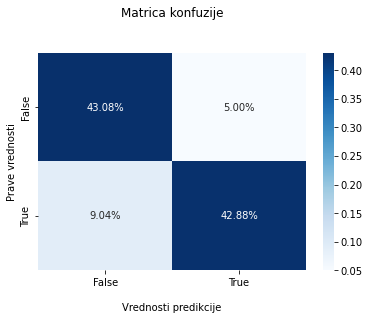

In [ ]:
cf_matrix = confusion_matrix(test['y'], predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matrica konfuzije\n\n');
ax.set_xlabel('\nVrednosti predikcije')
ax.set_ylabel('Prave vrednosti');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

[5p] Navesti 3 primera u kojima izrazito želimo da imamo što manje FP čak i na račun povećanja FN i 3 primera kada važi obrnuto – želimo da imamo što manje FN čak i na račun povećanja broja FP. 

> False Postive:
Primeri u kojima izrazito zelimo da imamo sto manje False Positive

1) Ne zelimo lazno pozitivan test ukoliko su u pitanju rezultati merenja vrednsoti u zdravstvene svrhe. (Lazno pozitivan test na koronu)

2) Ne zelimo kada se vrsi testiranje na drogu. (Ukoliko se vrsi testiranje unutar neke firme da nas test ispadne lazno pozitivan)

3) Prilikom sudjenja ukoliko osoba bude proglasena krivom, a nevina je.

> False Negative:
Primeri u kojima izrazito zelimo da imamo sto manje False Negative

1) Prilikom sudjenja ukoliko osoba bude proglasena nevinom, a kriva je.

2) Kontrola kvaliteta u proizvodnji, lazni negativni test u ovoj oblasti znači da neispravna stvar prolazi kroz pukotine.

3) U testiranju softvera, rezultati lazno negativanog testa bi značili da je test dizajniran da uhvati nešto (tj. virus), a nije uspeo.